## Разбор практического задания №5 по теме "Рекуррентные нейронные сети".

###  Задание:

Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Flatten
from keras.layers.recurrent import SimpleRNN, LSTM, GRU

In [ ]:
tf.random.set_seed(1)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
airline_passengers_data = pd.read_csv('data/airline-passengers.csv')

In [ ]:
airline_passengers_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
airline_passengers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
airline_passengers_data['Month'].value_counts()

1949-01    1
1949-02    1
1956-09    1
1956-10    1
1956-11    1
          ..
1953-01    1
1953-02    1
1953-03    1
1953-04    1
1960-12    1
Name: Month, Length: 144, dtype: int64

Распарсим дату

In [ ]:
airline_passengers_data['Month'] = pd.to_datetime(airline_passengers_data['Month'], format='%Y-%m')

In [ ]:
def parse_date(df, date_feature_name):
    date_list = df[date_feature_name]
    years = []
    months = []
    for el in date_list:
        years.append(el.year)
        months.append(el.month)
    df['year'] = years
    df['mon'] = months

    return df

In [ ]:
airline_passengers_data = parse_date(airline_passengers_data, 'Month')

Отбросим первый столбец, т.к. признаки [year, mon] его представляют.

In [ ]:
data = airline_passengers_data.iloc[:, 1:]
data.head()

,Passengers,year,mon
0,112,1949,1
1,118,1949,2
2,132,1949,3
3,129,1949,4
4,121,1949,5


Разбиваем выборку на обучение и на тест.

In [ ]:
train_size = 100


# список признаков, по которым будем учить
features = ['Passengers', 'year', 'mon']


# отступ теста от тренировки
bias = 5


# делим
train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 3), (39, 3))

Создаем данные для обучения

In [ ]:
features = train_data.columns[1:]
target = train_data.columns[0]

In [ ]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,year,mon
0,112,-1.525724,-1.534863
1,118,-1.525724,-1.247435
2,132,-1.525724,-0.960008
3,129,-1.525724,-0.672580
4,121,-1.525724,-0.385153


Формируем параметры для генерации выборки

In [ ]:
# длина истории
x_len = 3

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 8
epochs = 10

In [ ]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

4 104
35 109


In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (35, 2), (35,))

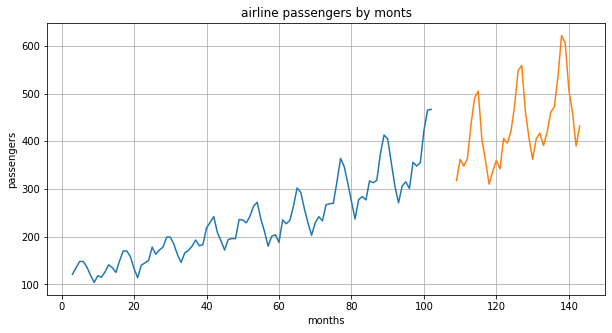

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('months')
plt.ylabel('passengers')
plt.title('airline passengers by monts')
plt.show()

In [ ]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [ ]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 3, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]], shape=(3, 2), dtype=float64)
Target shape: (8,)
tf.Tensor(135, shape=(), dtype=int64)


In [ ]:
results = pd.DataFrame() # сводная таблица результатов
model = [] # шаг
train_m = [] # результат на трейне
test_m = [] # результат на тесте

**SimpleRNN**

In [ ]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_1 = Sequential()

model_1.add(SimpleRNN(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Conv1D(64, 1, activation='linear'))
model_1.add(Flatten())
model_1.add(Dense(3, activation='linear'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 32)             1120      
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             6208      
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 11,687
Trainable params: 11,687
Non-traina

In [ ]:
history_1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 11s 43ms/step - loss: 57002.5820 - mae: 226.1154 - val_loss: 195057.7500 - val_mae: 434.3455
Epoch 2/10
13/13 [==============================] - 0s 16ms/step - loss: 56569.2969 - mae: 225.2039 - val_loss: 193480.7500 - val_mae: 432.5594
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 56389.5977 - mae: 225.0341 - val_loss: 191998.6250 - val_mae: 430.8818
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 56045.5664 - mae: 224.5570 - val_loss: 189399.2344 - val_mae: 427.9258
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 55135.5117 - mae: 223.1457 - val_loss: 183160.6562 - val_mae: 420.7309
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 52438.2812 - mae: 218.6344 - val_loss: 166946.7031 - val_mae: 401.3586
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 44549.7461 - mae: 203.7057 - val_loss: 127731.8906 - val_mae: 

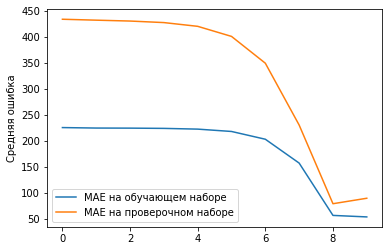

In [ ]:
plt.plot(history_1.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_1.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
hist_val_1 = history_1.history['val_mae']
hist_train_1 = history_1.history['mae']

In [ ]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 1636.3713 - mae: 31.2918 - val_loss: 20042.8594 - val_mae: 121.9034
Epoch 2/10
13/13 [==============================] - 0s 14ms/step - loss: 1387.1542 - mae: 29.8463 - val_loss: 14377.1865 - val_mae: 98.3818
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 1509.0913 - mae: 31.0266 - val_loss: 13719.3516 - val_mae: 95.7817
Epoch 4/10
13/13 [==============================] - 0s 30ms/step - loss: 1348.6465 - mae: 29.0808 - val_loss: 14504.1143 - val_mae: 99.9307
Epoch 5/10
13/13 [==============================] - 0s 26ms/step - loss: 1297.3878 - mae: 28.6926 - val_loss: 13678.4668 - val_mae: 96.2485
Epoch 6/10
13/13 [==============================] - 0s 24ms/step - loss: 1268.8689 - mae: 28.2431 - val_loss: 13337.0928 - val_mae: 94.8213
Epoch 7/10
13/13 [==============================] - 0s 31ms/step - loss: 1211.2448 - mae: 27.4912 - val_loss: 13134.6172 - val_mae: 94.0796
Epoch 8/10
13/13 [=

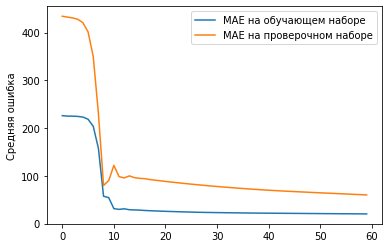

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 639.2451 - mae: 20.2185 - val_loss: 5933.0342 - val_mae: 59.6611
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 633.7018 - mae: 20.1311 - val_loss: 5848.7930 - val_mae: 59.1964
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 628.0192 - mae: 20.0421 - val_loss: 5764.5107 - val_mae: 58.7262
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 622.1753 - mae: 19.9549 - val_loss: 5680.0156 - val_mae: 58.2499
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 616.1462 - mae: 19.8639 - val_loss: 5595.1416 - val_mae: 57.7663
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 609.9070 - mae: 19.7681 - val_loss: 5509.7290 - val_mae: 57.2746
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 603.4303 - mae: 19.6722 - val_loss: 5423.6094 - val_mae: 56.7739
Epoch 8/10
13/13 [================

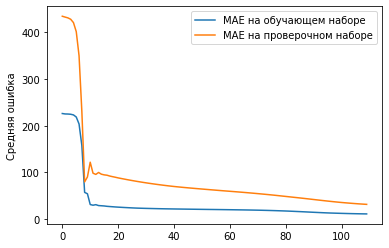

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 184.3109 - mae: 11.1198 - val_loss: 1845.1481 - val_mae: 31.3150
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 180.4615 - mae: 11.0157 - val_loss: 1813.1287 - val_mae: 30.9631
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 176.7279 - mae: 10.9101 - val_loss: 1782.8920 - val_mae: 30.6256
Epoch 4/10
13/13 [==============================] - 0s 12ms/step - loss: 173.0970 - mae: 10.8028 - val_loss: 1754.3086 - val_mae: 30.2946
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 169.5661 - mae: 10.6940 - val_loss: 1727.2384 - val_mae: 29.9693
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 166.1348 - mae: 10.5839 - val_loss: 1701.6321 - val_mae: 29.7224
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 162.7931 - mae: 10.4722 - val_loss: 1677.2854 - val_mae: 29.5543
Epoch 8/10
13/13 [================

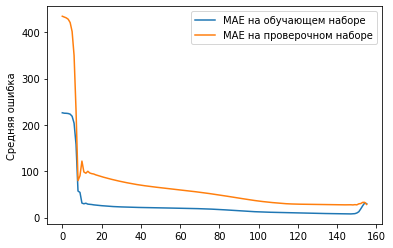

Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 648.9225 - mae: 19.7587 - val_loss: 1548.6387 - val_mae: 28.4735
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 1004.9724 - mae: 29.2829 - val_loss: 1641.7178 - val_mae: 30.3280
Epoch 3/10
13/13 [==============================] - 0s 14ms/step - loss: 1072.0463 - mae: 29.1118 - val_loss: 1816.5933 - val_mae: 31.3413
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 842.2591 - mae: 24.4164 - val_loss: 1525.9750 - val_mae: 30.2558
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 345.0421 - mae: 16.3469 - val_loss: 1858.8063 - val_mae: 31.0591
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 183.5118 - mae: 11.6977 - val_loss: 1487.2233 - val_mae: 28.8532
Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 141.9769 - mae: 9.0430 - val_loss: 1599.6605 - val_mae: 29.0858
Epoch 2/10
13/13 [===============

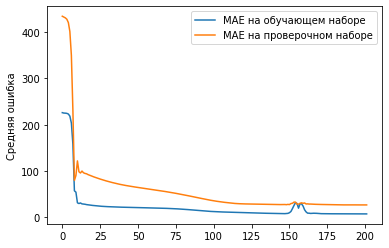

Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 91.8075 - mae: 7.3342 - val_loss: 1127.3090 - val_mae: 26.7397
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 91.1330 - mae: 7.3915 - val_loss: 1128.2731 - val_mae: 26.8508
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 91.0627 - mae: 7.3265 - val_loss: 1118.4594 - val_mae: 26.6923
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 91.0868 - mae: 7.3372 - val_loss: 1126.0986 - val_mae: 26.7989
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 91.3585 - mae: 7.3918 - val_loss: 1118.1250 - val_mae: 26.7726
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 91.0329 - mae: 7.2871 - val_loss: 1116.5513 - val_mae: 26.6596
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 90.2388 - mae: 7.3764 - val_loss: 1122.8418 - val_mae: 26.8762
Epoch 8/10
13/13 [==============================

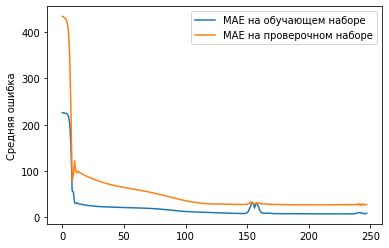

In [ ]:
for iteration in range(num_iterations):
  history_1 = model_1.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_1.extend(history_1.history['val_mae'][:])
  hist_train_1.extend(history_1.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_1, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_1, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [ ]:
pred_1 = model_1.predict(dataset_train).flatten()
pred_val_1 = model_1.predict(dataset_val).flatten()

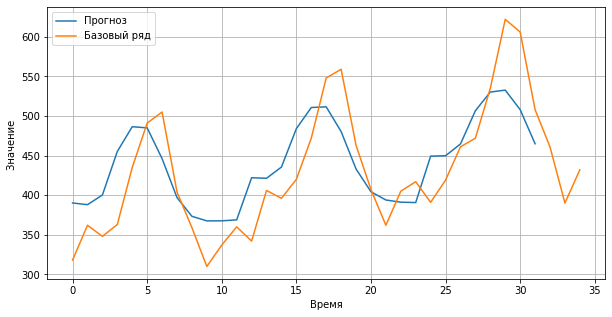

In [ ]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

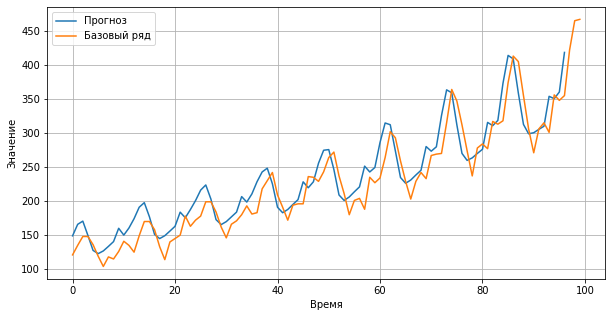

In [ ]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [ ]:
train_loss_1, train_m_1 = model_1.evaluate(dataset_train)
test_loss_1, test_m_1 = model_1.evaluate(dataset_val)
print(f'train_loss: {train_loss_1}, train_m: {train_m_1}')
print(f'test_loss: {test_loss_1}, test_m: {test_m_1}')

model.append('SimpleRNN')
train_m.append(round(train_m_1,2))
test_m.append(round(test_m_1,2))

5/5 [==============================] - 0s 6ms/step - loss: 1161.1674 - mae: 27.4316
train_loss: 209.86463928222656, train_m: 11.940805435180664
test_loss: 1161.1673583984375, test_m: 27.431560516357422


**LSTM**

In [ ]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_2 = Sequential()

model_2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(LSTM(32, return_sequences=True))
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4480      
                                                                 
 lstm_1 (LSTM)               (None, 3, 32)             8320      
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 8s 82ms/step - loss: 56648.3672 - mae: 225.6246 - val_loss: 193018.7031 - val_mae: 432.0194
Epoch 2/10
13/13 [==============================] - 1s 44ms/step - loss: 56365.4727 - mae: 225.0315 - val_loss: 192135.5625 - val_mae: 431.0099
Epoch 3/10
13/13 [==============================] - 1s 44ms/step - loss: 55525.9727 - mae: 223.3376 - val_loss: 189049.2969 - val_mae: 427.4778
Epoch 4/10
13/13 [==============================] - 1s 43ms/step - loss: 52735.5508 - mae: 217.6819 - val_loss: 178290.2188 - val_mae: 414.9871
Epoch 5/10
13/13 [==============================] - 1s 43ms/step - loss: 44167.4180 - mae: 199.4041 - val_loss: 145052.2500 - val_mae: 373.8962
Epoch 6/10
13/13 [==============================] - 1s 42ms/step - loss: 23246.1816 - mae: 144.3253 - val_loss: 68547.1641 - val_mae: 254.3223
Epoch 7/10
13/13 [==============================] - 1s 45ms/step - loss: 2569.2405 - mae: 40.0729 - val_loss: 9501.3584 - val_mae: 83.895

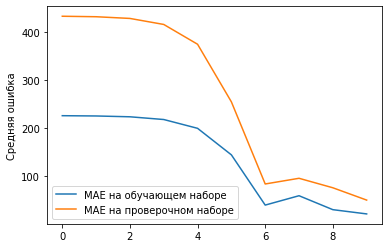

In [ ]:
plt.plot(history_2.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']

In [ ]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 1s 43ms/step - loss: 738.9323 - mae: 21.3838 - val_loss: 4938.0562 - val_mae: 51.6484
Epoch 2/10
13/13 [==============================] - 1s 41ms/step - loss: 683.1404 - mae: 20.2212 - val_loss: 4627.1729 - val_mae: 49.8158
Epoch 3/10
13/13 [==============================] - 1s 42ms/step - loss: 689.4874 - mae: 20.3385 - val_loss: 4384.3032 - val_mae: 48.4672
Epoch 4/10
13/13 [==============================] - 1s 44ms/step - loss: 682.7075 - mae: 20.2199 - val_loss: 4476.6514 - val_mae: 48.9618
Epoch 5/10
13/13 [==============================] - 1s 42ms/step - loss: 679.9597 - mae: 20.1943 - val_loss: 4386.9624 - val_mae: 48.4534
Epoch 6/10
13/13 [==============================] - 1s 41ms/step - loss: 675.8958 - mae: 20.1469 - val_loss: 4367.8081 - val_mae: 48.3282
Epoch 7/10
13/13 [==============================] - 1s 40ms/step - loss: 672.0255 - mae: 20.1027 - val_loss: 4318.5850 - val_mae: 48.0244
Epoch 8/10
13/13 [================

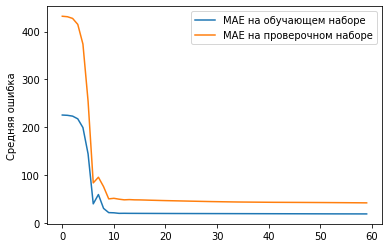

Epoch 1/10
13/13 [==============================] - 1s 41ms/step - loss: 583.7479 - mae: 19.0226 - val_loss: 3027.1467 - val_mae: 42.0453
Epoch 2/10
13/13 [==============================] - 1s 40ms/step - loss: 581.7122 - mae: 18.9984 - val_loss: 3008.1650 - val_mae: 41.9371
Epoch 3/10
13/13 [==============================] - 1s 41ms/step - loss: 579.5816 - mae: 18.9722 - val_loss: 2989.4788 - val_mae: 41.8217
Epoch 4/10
13/13 [==============================] - 1s 40ms/step - loss: 577.3461 - mae: 18.9525 - val_loss: 2971.0122 - val_mae: 41.6992
Epoch 5/10
13/13 [==============================] - 1s 40ms/step - loss: 574.9945 - mae: 18.9306 - val_loss: 2951.9907 - val_mae: 41.5633
Epoch 6/10
13/13 [==============================] - 1s 38ms/step - loss: 572.5095 - mae: 18.9074 - val_loss: 2933.0315 - val_mae: 41.4184
Epoch 7/10
13/13 [==============================] - 1s 42ms/step - loss: 569.8795 - mae: 18.8811 - val_loss: 2913.9258 - val_mae: 41.2653
Epoch 8/10
13/13 [================

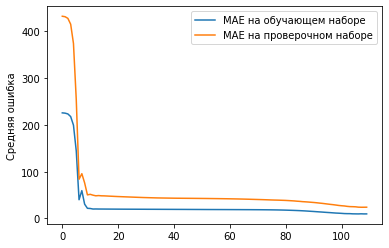

Epoch 1/10
13/13 [==============================] - 1s 44ms/step - loss: 164.5762 - mae: 9.7928 - val_loss: 867.1516 - val_mae: 23.2564
Epoch 2/10
13/13 [==============================] - 1s 42ms/step - loss: 170.5169 - mae: 10.6267 - val_loss: 869.0414 - val_mae: 23.5614
Epoch 3/10
13/13 [==============================] - 1s 41ms/step - loss: 171.7693 - mae: 10.5987 - val_loss: 911.9678 - val_mae: 23.7995
Epoch 4/10
13/13 [==============================] - 1s 40ms/step - loss: 190.1739 - mae: 10.9853 - val_loss: 940.3943 - val_mae: 24.8371
Epoch 5/10
13/13 [==============================] - 1s 45ms/step - loss: 214.4590 - mae: 11.0643 - val_loss: 825.3552 - val_mae: 22.7780
Epoch 6/10
13/13 [==============================] - 1s 42ms/step - loss: 241.0430 - mae: 13.1449 - val_loss: 898.1849 - val_mae: 24.0846
Epoch 7/10
13/13 [==============================] - 1s 41ms/step - loss: 278.6494 - mae: 13.9085 - val_loss: 1015.3852 - val_mae: 25.5977
Epoch 8/10
13/13 [=======================

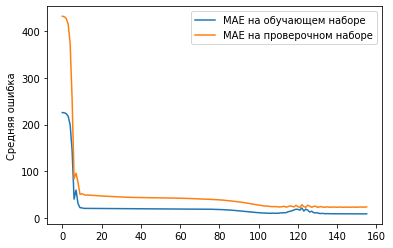

Epoch 1/10
13/13 [==============================] - 1s 42ms/step - loss: 119.4237 - mae: 8.5146 - val_loss: 789.8432 - val_mae: 23.2231
Epoch 2/10
13/13 [==============================] - 1s 41ms/step - loss: 121.5271 - mae: 8.4081 - val_loss: 771.7584 - val_mae: 22.8873
Epoch 3/10
13/13 [==============================] - 1s 40ms/step - loss: 122.2839 - mae: 8.5603 - val_loss: 801.2453 - val_mae: 23.4728
Epoch 4/10
13/13 [==============================] - 1s 41ms/step - loss: 118.4437 - mae: 8.4926 - val_loss: 812.1831 - val_mae: 23.7042
Epoch 5/10
13/13 [==============================] - 1s 42ms/step - loss: 121.6801 - mae: 8.5522 - val_loss: 771.5223 - val_mae: 22.9508
Epoch 6/10
13/13 [==============================] - 1s 43ms/step - loss: 124.2948 - mae: 8.4627 - val_loss: 779.0247 - val_mae: 23.0940
Epoch 7/10
13/13 [==============================] - 1s 40ms/step - loss: 121.8662 - mae: 8.6669 - val_loss: 825.8911 - val_mae: 23.9838
Epoch 1/10
13/13 [==============================

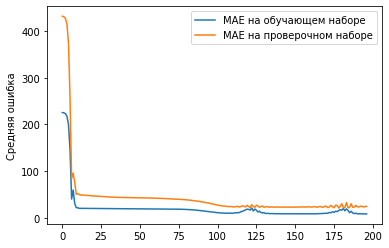

Epoch 1/10
13/13 [==============================] - 1s 44ms/step - loss: 114.5738 - mae: 8.3552 - val_loss: 785.3071 - val_mae: 23.5203
Epoch 2/10
13/13 [==============================] - 1s 39ms/step - loss: 115.3233 - mae: 8.1969 - val_loss: 793.5490 - val_mae: 23.6334
Epoch 3/10
13/13 [==============================] - 1s 42ms/step - loss: 115.3256 - mae: 8.4000 - val_loss: 831.9217 - val_mae: 24.4160
Epoch 4/10
13/13 [==============================] - 1s 43ms/step - loss: 112.7843 - mae: 8.2597 - val_loss: 802.0434 - val_mae: 23.9371
Epoch 5/10
13/13 [==============================] - 1s 43ms/step - loss: 114.8819 - mae: 8.2320 - val_loss: 782.7960 - val_mae: 23.5130
Epoch 6/10
13/13 [==============================] - 1s 41ms/step - loss: 115.3100 - mae: 8.3193 - val_loss: 817.0403 - val_mae: 24.1718
Epoch 7/10
13/13 [==============================] - 1s 40ms/step - loss: 112.6465 - mae: 8.2349 - val_loss: 818.0204 - val_mae: 24.2793
Epoch 8/10
13/13 [==============================

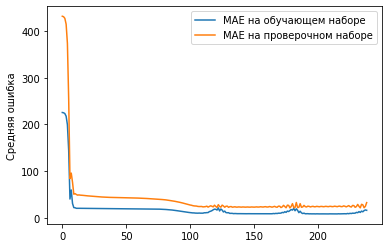

In [ ]:
for iteration in range(num_iterations):
  history_2 = model_2.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_2.extend(history_2.history['val_mae'][:])
  hist_train_2.extend(history_2.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_2, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [ ]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_val).flatten()

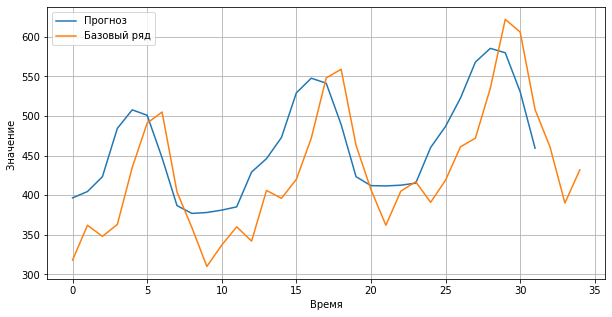

In [ ]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

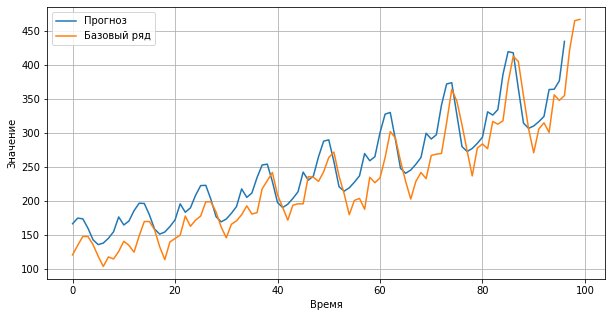

In [ ]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [ ]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_val)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')

model.append('LSTM')
train_m.append(round(train_m_2,2))
test_m.append(round(test_m_2,2))

5/5 [==============================] - 0s 6ms/step - loss: 1373.7465 - mae: 32.3882
train_loss: 554.2384033203125, train_m: 21.112661361694336
test_loss: 1373.7464599609375, test_m: 32.38817596435547


**GRU**

In [ ]:
# установка ряда метапареметров  для нейронной сети и процесса тренировки
batch_size = 8
hidden_size = 32
num_iterations = 25 
num_epochs = 1
num_preds = 100

In [ ]:
model_3 = Sequential()
model_3.add(
    GRU(
        hidden_size,
        return_sequences=True,
        input_shape=(inputs.shape[1], inputs.shape[2]),
        unroll=True
    )
)
model_3.add(Conv1D(64, 3, activation='linear'))
model_3.add(Conv1D(64, 1, activation='linear'))
model_3.add(Flatten())
model_3.add(Dense(3, activation='linear'))
model_3.add(Dense(1, activation='linear'))

model_3.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 32)             3360      
                                                                 
 conv1d_4 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
 dense_5 (Dense)             (None, 1)                 4         
                                                                 
Total params: 13,927
Trainable params: 13,927
Non-trai

In [ ]:
history_3 = model_3.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 2s 36ms/step - loss: 56770.3516 - mae: 225.8175 - val_loss: 193739.2812 - val_mae: 432.8346
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 56498.1641 - mae: 225.2371 - val_loss: 192679.8125 - val_mae: 431.6387
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 56237.4609 - mae: 224.8073 - val_loss: 191091.1875 - val_mae: 429.8397
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 55648.7539 - mae: 223.7865 - val_loss: 187513.5469 - val_mae: 425.7600
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 54123.7969 - mae: 221.0768 - val_loss: 178458.1406 - val_mae: 415.2464
Epoch 6/10
13/13 [==============================] - 0s 14ms/step - loss: 50124.8047 - mae: 213.6656 - val_loss: 156040.2344 - val_mae: 387.9535
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 40461.6289 - mae: 193.9047 - val_loss: 107251.1953 - val_mae: 3

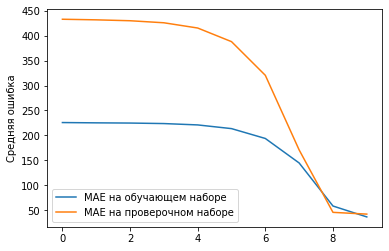

In [ ]:
plt.plot(history_3.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_3.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
hist_val_3 = history_3.history['val_mae']
hist_train_3 = history_3.history['mae']

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 895.2253 - mae: 23.0919 - val_loss: 7178.4736 - val_mae: 62.7519
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 675.9417 - mae: 19.7248 - val_loss: 4652.0845 - val_mae: 48.9764
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 702.5638 - mae: 20.5844 - val_loss: 4375.4536 - val_mae: 47.5980
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 650.1905 - mae: 19.6698 - val_loss: 4594.7715 - val_mae: 48.9260
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 652.0953 - mae: 20.0704 - val_loss: 4253.0996 - val_mae: 46.9609
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 651.4010 - mae: 19.9257 - val_loss: 4292.9092 - val_mae: 47.1340
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 644.1842 - mae: 19.7088 - val_loss: 4290.6021 - val_mae: 47.1030
Epoch 8/10
13/13 [================

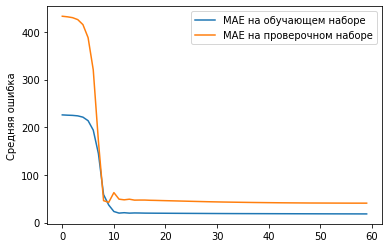

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 543.9451 - mae: 18.0174 - val_loss: 3045.0173 - val_mae: 40.5993
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 542.6488 - mae: 17.9974 - val_loss: 3036.4402 - val_mae: 40.5874
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 541.3780 - mae: 17.9776 - val_loss: 3028.1692 - val_mae: 40.5734
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 540.1367 - mae: 17.9583 - val_loss: 3020.1377 - val_mae: 40.5577
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 538.9188 - mae: 17.9411 - val_loss: 3012.3022 - val_mae: 40.5418
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 537.7221 - mae: 17.9245 - val_loss: 3004.6472 - val_mae: 40.5446
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 536.5464 - mae: 17.9077 - val_loss: 2997.1621 - val_mae: 40.5452
Epoch 8/10
13/13 [================

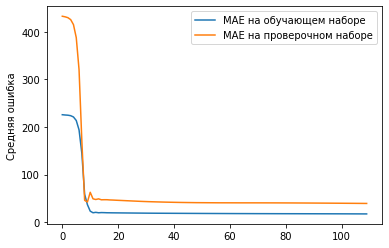

Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 490.8203 - mae: 17.2394 - val_loss: 2717.2881 - val_mae: 39.2367
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 489.3733 - mae: 17.2123 - val_loss: 2709.4585 - val_mae: 39.1854
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 487.8659 - mae: 17.1838 - val_loss: 2701.4099 - val_mae: 39.1315
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 486.2897 - mae: 17.1560 - val_loss: 2693.2097 - val_mae: 39.0750
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 484.6392 - mae: 17.1267 - val_loss: 2684.8333 - val_mae: 39.0159
Epoch 6/10
13/13 [==============================] - 0s 14ms/step - loss: 482.9131 - mae: 17.0957 - val_loss: 2676.1934 - val_mae: 38.9536
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 481.1040 - mae: 17.0630 - val_loss: 2667.2207 - val_mae: 38.9096
Epoch 8/10
13/13 [================

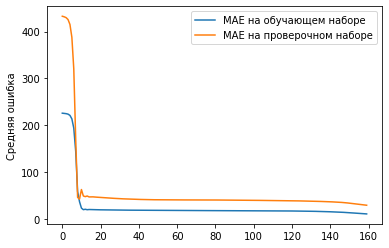

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 178.0109 - mae: 10.4090 - val_loss: 1188.2368 - val_mae: 28.7419
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 170.8573 - mae: 10.1481 - val_loss: 1145.2137 - val_mae: 28.2757
Epoch 3/10
13/13 [==============================] - 0s 14ms/step - loss: 164.5004 - mae: 9.9130 - val_loss: 1105.8760 - val_mae: 27.8122
Epoch 4/10
13/13 [==============================] - 0s 12ms/step - loss: 158.9185 - mae: 9.7064 - val_loss: 1070.3101 - val_mae: 27.4584
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 154.0337 - mae: 9.5407 - val_loss: 1038.2308 - val_mae: 27.1223
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 149.7536 - mae: 9.3844 - val_loss: 1009.8682 - val_mae: 26.8014
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 146.0946 - mae: 9.2551 - val_loss: 984.9854 - val_mae: 26.4981
Epoch 8/10
13/13 [======================

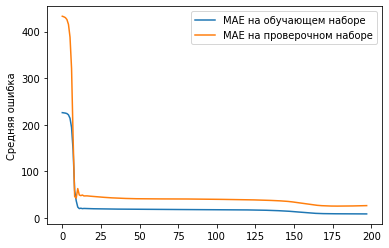

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 117.1397 - mae: 8.3215 - val_loss: 926.9058 - val_mae: 26.2540
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 116.8103 - mae: 8.3123 - val_loss: 932.6021 - val_mae: 26.3714
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 116.5067 - mae: 8.3034 - val_loss: 938.4026 - val_mae: 26.4884
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 116.2177 - mae: 8.2932 - val_loss: 943.7379 - val_mae: 26.5941
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 115.9110 - mae: 8.2822 - val_loss: 948.9756 - val_mae: 26.6953
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 115.6091 - mae: 8.2737 - val_loss: 955.1657 - val_mae: 26.8100
Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 115.3317 - mae: 8.2649 - val_loss: 961.5946 - val_mae: 26.9285
Epoch 2/10
13/13 [==============================

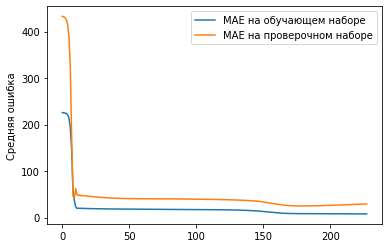

In [ ]:
for iteration in range(num_iterations):
  history_3 = model_3.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_3.extend(history_3.history['val_mae'][:])
  hist_train_3.extend(history_3.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_3, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_3, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [ ]:
pred_3 = model_3.predict(dataset_train).flatten()
pred_val_3 = model_3.predict(dataset_val).flatten()

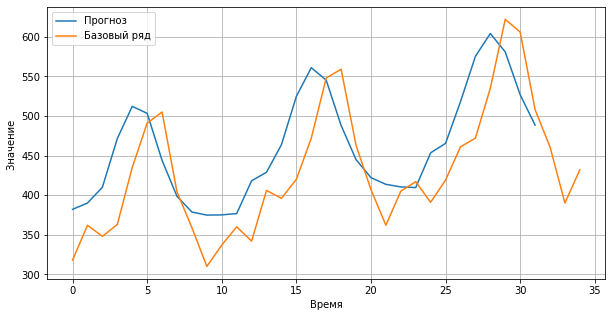

In [ ]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_3[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

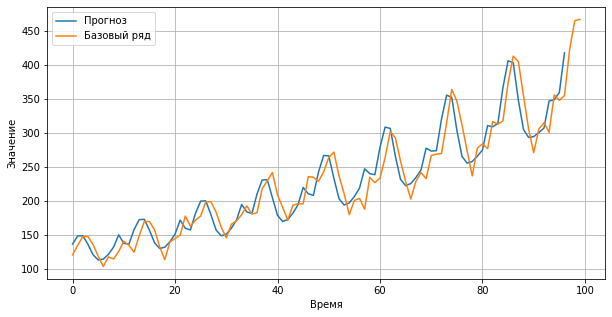

In [ ]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_3[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [ ]:
train_loss_3, train_m_3 = model_3.evaluate(dataset_train)
test_loss_3, test_m_3 = model_3.evaluate(dataset_val)
print(f'train_loss: {train_loss_3}, train_m: {train_m_3}')
print(f'test_loss: {test_loss_3}, test_m: {test_m_3}')

model.append('GRU')
train_m.append(round(train_m_3,2))
test_m.append(round(test_m_3,2))

5/5 [==============================] - 0s 4ms/step - loss: 1118.8779 - mae: 29.3369
train_loss: 95.51929473876953, train_m: 7.539565563201904
test_loss: 1118.8779296875, test_m: 29.336883544921875


Общий результат

In [ ]:
results['model'] = model
results['train_m'] = train_m
results['test_m'] = test_m

In [ ]:
results

,model,train_m,test_m
0,SimpleRNN,11.94,27.43
1,LSTM,21.11,32.39
2,GRU,7.54,29.34


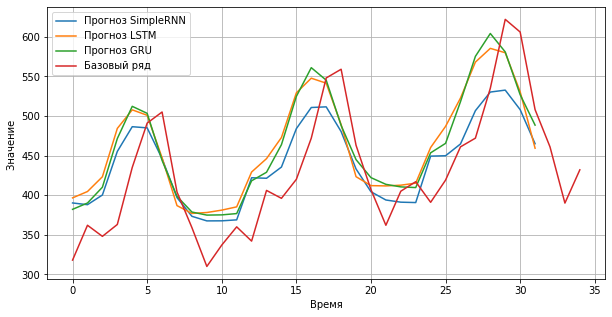

In [ ]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз SimpleRNN')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз LSTM')
plt.plot(pred_val_3[future + start: future + start + step], 
         label='Прогноз GRU')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

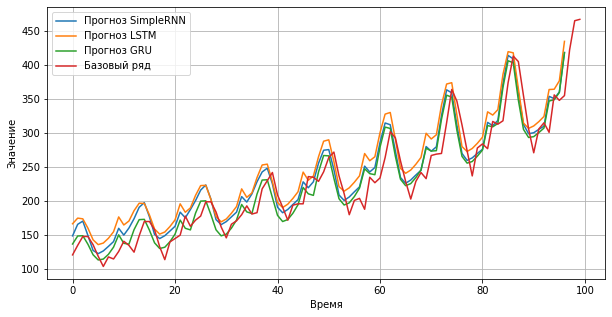

In [ ]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз SimpleRNN')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз LSTM')
plt.plot(pred_3[future + start: future + train_size], 
         label='Прогноз GRU')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

__Выводы:__
<br>

* чем больше итераций - тем выше качество (25 и правда хватает)
* для данного датасета лучше справился GRU, хотя LSTM сравним с ним по качеству

---